# FACS analysis

Flag-YFP-DHFR-puroR lentivirus in HEK293T GCN2KO : all 6 arg codon variants.  Same cells for combined 11 CV lib YFP mRNA/DNA seq experiment.  Used LV2 stock : 250 ul virus per 12 well plate well. Selected with 1.5 ug/ml puro.

*  plasmid reporters 
    1. YFP-WT: Flag-YFPwt-DHFRwt
    2. YFP-CGG: Flag-YFPcta-DHFRcgg
    3. YFP-CGA: Flag-YFPctc-DHFRcga
    4. YFP-CGT: Flag-YFPctt-DHFRcgt
    5. YFP-AGA: Flag-YFPtta-DHFRaga
    6. YFP-AGG: Flag-YFPttg-DHFRagg
* 8 conditions
    1. rich, +/- 10 uM TMP
    2. -leu, +/- 10 uM TMP
    3. -arg, +/- 10 uM TMP (for all - tmp is only for the 24 h time point).
* Measurement voltages: FSC = 280, SSC = 210, FITC = 275

### Analysis Steps
  0. consider mean of fcs/ssc gated population of 20000 events @ for each sample separately
  1. thresholding for reasonable FSC/SSC values and NO fluorescence value based thresholding
  2. rich condition normalization

### Globals

In [1]:
%matplotlib inline
# globals
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')
from FlowCytometryTools import FCMeasurement

In [2]:
# matplotlib default customizations
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color = ["#CC79A7", "#E69F00", "#D55E00",
               "#0072B2", "#56B4E9", "#009E73"])
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['axes.titlesize'] = 8
mpl.rcParams['lines.markersize'] = 4
mpl.rcParams['figure.subplot.hspace'] = 0.5
mpl.rcParams['figure.subplot.wspace'] = 0.5
mpl.rcParams['font.size'] = 8
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'

### Experiment Annotations

In [3]:
sampleids = {1: 'YFP-WT Rich TMP 1',
 2: 'YFP-WT -Leu TMP 1',
 3: 'YFP-WT -Arg TMP 1',
 4: 'YFP-CGG Rich TMP 1',
 5: 'YFP-CGG -Leu TMP 1',
 6: 'YFP-CGG -Arg TMP 1',
 7: 'YFP-CGA Rich TMP 1',
 8: 'YFP-CGA -Leu TMP 1',
 9: 'YFP-CGA -Arg TMP 1',
 10: 'YFP-CGT Rich TMP 1',
 11: 'YFP-CGT -Leu TMP 1',
 12: 'YFP-CGT -Arg TMP 1',
 13: 'YFP-AGA Rich TMP 1',
 14: 'YFP-AGA -Leu TMP 1',
 15: 'YFP-AGA -Arg TMP 1',
 16: 'YFP-AGG Rich TMP 1',
 17: 'YFP-AGG -Leu TMP 1',
 18: 'YFP-AGG -Arg TMP 1',
 19: 'YFP-WT Rich NOTMP 1',
 20: 'YFP-CGG Rich NOTMP 1',
 21: 'YFP-CGA Rich NOTMP 1',
 22: 'YFP-CGT Rich NOTMP 1',
 23: 'YFP-AGA Rich NOTMP 1',
 24: 'YFP-AGG Rich NOTMP 1'}

#make sure this is right!



timepoints = {
    'Specimen_001': 12,
    'Specimen_002': 24,
    'Specimen_004': 48,
 }

fsc_threshold = 30000
ssc_threshold = 12500

### Read in data and calculate median and mean after thresholding by FSC and SSC ###

In [4]:
fcsFiles = os.listdir('../fcs_files/')
fcsFiles = ['../fcs_files/' + File for File in fcsFiles if File.endswith('.fcs')]

processeddata = dict()
for File in fcsFiles:
    ID = int( File.split( '/' )[-1].split( '.' )[0].split('_')[-1] )
    sampleid = sampleids[ID]
    time = timepoints[re.search('Specimen_00\d+',File).group()]
    sampleid = sampleid.replace(' ','_') + '_%d'%time # replace space by _
    fcsdata = FCMeasurement(ID= sampleid, datafile=File)
    processeddata[ sampleid ] = dict()
    subset = np.logical_and( fcsdata.data['FSC-A'] > fsc_threshold, fcsdata.data['SSC-A'] > ssc_threshold )
    processeddata[ sampleid ]['fsc_median'] = fcsdata.data['FSC-A'][subset].median()
    processeddata[ sampleid ]['fitc_mean'] = fcsdata.data['FITC-A'][subset].mean()
    processeddata[ sampleid ]['fitc_median'] = fcsdata.data['FITC-A'][subset].median()
    processeddata[ sampleid ]['fitc_q25'] = fcsdata.data['FITC-A'][subset].quantile(q=0.25)    
    processeddata[ sampleid ]['fitc_q75'] = fcsdata.data['FITC-A'][subset].quantile(q=0.75)
    processeddata[ sampleid ]['fsc_q25'] = fcsdata.data['FSC-A'][subset].quantile(q=0.25)    
    processeddata[ sampleid ]['fsc_q75'] = fcsdata.data['FSC-A'][subset].quantile(q=0.75)       
    
data = pd.DataFrame.from_dict( processeddata, orient='index' )
#data

### Calculate Mean, Median and Stddev by Replicates

In [5]:
# create a sample label by removing replicate number
data['samplelabel'] = map( lambda x: '_'.join(x.split('_')[:-2] + [x.split('_')[-1]]), data.index)
# groupby sample label
groupeddata = data.groupby( ['samplelabel'] )
# calcuate median, std, mean of fitc channel across replicates
summarizedData = groupeddata['fitc_mean'].agg([np.mean, np.std, np.median]) ##THIS NEEDS TO BE FIXED

In [6]:
summarizedData

,mean,std,median
samplelabel,,,
YFP-AGA_-Arg_TMP_12,1331.340454,NaN,1331.340454
YFP-AGA_-Arg_TMP_24,1581.842407,NaN,1581.842407
YFP-AGA_-Arg_TMP_48,1917.343994,NaN,1917.343994
YFP-AGA_-Leu_TMP_12,1652.751831,NaN,1652.751831
YFP-AGA_-Leu_TMP_24,3111.634033,NaN,3111.634033
YFP-AGA_-Leu_TMP_48,5416.711426,NaN,5416.711426
YFP-AGA_Rich_NOTMP_24,129.296051,NaN,129.296051
YFP-AGA_Rich_TMP_12,1542.923950,NaN,1542.923950
YFP-AGA_Rich_TMP_24,2170.061523,NaN,2170.061523


### Subtract NoTMP background from TMP samples

In [7]:
tmpsamples = map( lambda x: x.find('NOTMP') == -1, summarizedData.index)
summarizedDataTmp = summarizedData[tmpsamples]
summarizedDataNoTmp = summarizedData[np.logical_not(tmpsamples)]
summarizedDataNoTmp.index = map( lambda x: x.replace('_NOTMP',''), summarizedDataNoTmp.index)
summarizedDataTmp.index = map( lambda x: x.replace('_TMP',''), summarizedDataTmp.index)

In [8]:
summarizedDataTmp

,mean,std,median
YFP-AGA_-Arg_12,1331.340454,NaN,1331.340454
YFP-AGA_-Arg_24,1581.842407,NaN,1581.842407
YFP-AGA_-Arg_48,1917.343994,NaN,1917.343994
YFP-AGA_-Leu_12,1652.751831,NaN,1652.751831
YFP-AGA_-Leu_24,3111.634033,NaN,3111.634033
YFP-AGA_-Leu_48,5416.711426,NaN,5416.711426
YFP-AGA_Rich_12,1542.923950,NaN,1542.923950
YFP-AGA_Rich_24,2170.061523,NaN,2170.061523
YFP-AGA_Rich_48,2228.230957,NaN,2228.230957
YFP-AGG_-Arg_12,1921.270996,NaN,1921.270996


In [9]:
summarizedDataNoTmp

,mean,std,median
YFP-AGA_Rich_24,129.296051,NaN,129.296051
YFP-AGG_Rich_24,218.966599,NaN,218.966599
YFP-CGA_Rich_24,158.465347,NaN,158.465347
YFP-CGG_Rich_24,226.445602,NaN,226.445602
YFP-CGT_Rich_24,196.102371,NaN,196.102371
YFP-WT_Rich_24,246.251663,NaN,246.251663


In [11]:
meanSubtractedData = pd.DataFrame()
meanSubtractedData['mean'] = summarizedDataTmp['mean'] - summarizedDataNoTmp['mean']
meanSubtractedData['std'] = np.sqrt(np.square(summarizedDataTmp['std']) + np.square(summarizedDataNoTmp['std']))

### Normalize by the 'Rich' sample for both mean, median and adjust Stddev

In [10]:
def normalize(row, statistic):
    split = row[0].split('_')
    normalizationsample = '_'.join(split[:1]  + ['Rich'] + split[2:])
    return row[1][statistic] / summarizedDataTmp.ix[normalizationsample][statistic]

def normalizestdevmean(row):
    split = row[0].split('_')
    normalizationsample = '_'.join(split[:1]  + ['Rich'] + split[2:])    
    return row[1]['normalizedMean'] * np.sqrt(
                                           np.square(row[1]['std']/row[1]['mean']) +
                                          np.square(summarizedDataTmp.ix[normalizationsample]['std'] / 
                                          summarizedDataTmp.ix[normalizationsample]['mean']) )

for statistic in ['mean']:
    summarizedDataTmp['normalized' + statistic.capitalize()] = map(
        lambda row: normalize(row, statistic), summarizedDataTmp.iterrows()
    )
    
summarizedDataTmp['normalizedStd'] = map( normalizestdevmean, summarizedDataTmp.iterrows())
summarizedDataTmp['normalizedStdErr'] = summarizedDataTmp['normalizedStd'] / np.sqrt(3)
summarizedDataTmp['stderr'] = summarizedDataTmp['std'] / np.sqrt(3)
summarizedDataTmp['samplelabel'] = summarizedDataTmp.index
summarizedDataNoTmp['samplelabel'] =  summarizedDataNoTmp.index

/Users/aliciadarnell/PAPER/lib/python2.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/aliciadarnell/PAPER/lib/python2.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/aliciadarnell/PAPER/lib/python2.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

### Plot time series of mean data for 3 conditions and all variants

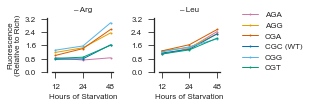

In [13]:

conditions = ['-Arg','-Leu']
times = ['12','24','48']
#sampleOrder = np.array([1,4,0,2,3,5])
xlocations =np.array([0,1,2])
variants = ['AGA','AGG','CGA','WT','CGG','CGT']

fig = plt.figure()

axcount = 0
for condition in conditions:
    axcount += 1
    ax = fig.add_subplot(1,2,axcount)
    for variant in variants:
        subset = np.logical_and(
        summarizedDataTmp['samplelabel'].apply(
            lambda label: label.find(variant) != -1
        ),
        summarizedDataTmp['samplelabel'].apply(
            lambda label: label.find(condition) != -1
        )
        )
        subsetdata = summarizedDataTmp[subset]
        x = xlocations
        y = subsetdata['normalizedMean']
        ax.plot(x, y, marker = 'o', markersize=2, linewidth=1, label = variant.replace('WT','CGC (WT)'))
        
    spineOffset = {'left': 5, 'bottom': 0}   
    [ spine.set_position(('outward',spineOffset[loc])) 
         if loc in ['left','bottom'] else spine.set_color('none') 
         for loc, spine in ax.spines.items() ]         
    ax.xaxis.set( ticks_position = 'bottom')
    ax.yaxis.set( ticks_position = 'left')
    timepoints = map(lambda x: x.split('_')[-1], subsetdata.index)
    ax.xaxis.set(ticks = x, ticklabels = timepoints)
    ax.set_xlim(-0.1,max(x) + 0.1)
    ax.set_ylim(bottom = 0, top = 3.25)
    ax.yaxis.set( major_locator = MaxNLocator(5) )
    ax.set_xlabel('Hours of Starvation')
    if axcount == 1:
        ax.set_ylabel('Fluorescence\n(Relative to Rich)')
    if axcount == 2:
        ax.legend(loc = 2, bbox_to_anchor = (1.25,1.25))
    ax.set_title(condition.replace('-',u'– '))  
    
fig.set_size_inches([3,1])
fig.subplots_adjust(wspace = 0.75)
fig.savefig('../figures/20170322_normalizedmean__nonotmpsub_all6arg_linegraph_2redo48_coloradj_forpaperv2.svg')
fig.savefig('../figures/20170322_normalizedmean__nonotmpsub_all6arg_linegraph_2redo48_coloradj_forpaperv2.pdf',bbox_inches='tight')

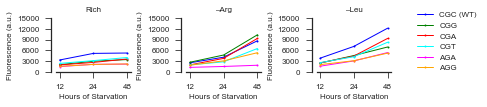

In [66]:

conditions = ['Rich','-Arg','-Leu']
times = ['12','24','48']
#sampleOrder = np.array([1,4,0,2,3,5])
xlocations =np.array([0,1,2])
variants = ['WT','CGG','CGA','CGT','AGA','AGG']

fig = plt.figure()

axcount = 0
for condition in conditions:
    axcount += 1
    ax = fig.add_subplot(1,3,axcount)
    for variant in variants:
        subset = np.logical_and(
        summarizedDataTmp['samplelabel'].apply(
            lambda label: label.find(variant) != -1
        ),
        summarizedDataTmp['samplelabel'].apply(
            lambda label: label.find(condition) != -1
        )
        )
        subsetdata = summarizedDataTmp[subset]
        x = xlocations
        y = subsetdata['mean']
        ax.plot(x, y, label = variant.replace('WT','CGC (WT)'),marker = 'o',markersize=2,linewidth=1)
        
    spineOffset = {'left': 5, 'bottom': 0}   
    [ spine.set_position(('outward',spineOffset[loc])) 
         if loc in ['left','bottom'] else spine.set_color('none') 
         for loc, spine in ax.spines.items() ]         
    ax.xaxis.set( ticks_position = 'bottom')
    ax.yaxis.set( ticks_position = 'left')
    timepoints = map(lambda x: x.split('_')[-1], subsetdata.index)
    ax.xaxis.set(ticks = x, ticklabels = timepoints)
    ax.set_xlim(-0.1,max(x) + 0.1)
    ax.set_ylim(bottom = 0, top = 15000)
    ax.yaxis.set( major_locator = MaxNLocator(5) )
    ax.set_xlabel('Hours of Starvation')
    ax.set_ylabel('Fluorescence (a.u.)')
    if axcount == 3:
        ax.legend(loc = 2, bbox_to_anchor = (1.25,1.25))
    ax.set_title(condition.replace('-',u'– '))  
    
fig.set_size_inches([6,1])
fig.subplots_adjust(wspace = 0.75)
fig.savefig('../figures/20170322_rawdatamean__nonotmpsub_all6arg_linegraph_2redo48_forpaper.svg')
#fig.savefig('../figures/20170322_rawdatamean__nonotmpsub_all6arg_linegraph_2redo48.pdf',bbox_inches='tight')


worried that by the 48h time point there might be differential changes in codons in starved relative to rich due to diff seeding densities in rich and thus diff points at which rich conditions hits media depletion & starts accumulating reporter (i.e. CGA) -- repeat w/o letting rich hit confluency?

^ yep , issue fixed by repeating 48 h time point w/ same settings / cells!

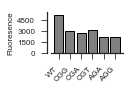

In [111]:
conditions = ['Rich']
times = ['12','24','48']
sampleOrder = np.array([52,34,25,43,7,16])
xlocations =np.array([0,1,2,3,4,5])
variants = ['WT','CGG','CGA','CGT','AGA','AGG']

fig = plt.figure()
ax = fig.add_subplot(111)



ax.bar(xlocations, summarizedDataTmp['mean'][sampleOrder], align='center', facecolor = 'grey',edgecolor='black',linewidth=1 )
#ax.errorbar(xlocations, data['relative_s35met'][sampleOrder], 
            #data['sem'][sampleOrder], linestyle='None', color = 'black', elinewidth=0.5, capsize=2, capthick=0.5 )

spineOffset = {'left': 4, 'bottom': 0}   
[ spine.set_position(('outward',spineOffset[loc])) 
     if loc in ['left','bottom'] else spine.set_color('none') 
     for loc, spine in ax.spines.items() ]         
ax.xaxis.set( ticks_position = 'bottom')
ax.yaxis.set( ticks_position = 'left')
ax.yaxis.set( major_locator = MaxNLocator(5) )
ax.set_ylim(0,5500)
ax.set_xticks(xlocations)
xticklabels= variants
ax.set_xticklabels(xticklabels, rotation=45, ha='right')

ax.set_ylabel( 'Fluoresence')

fig.set_size_inches([1.29,.75])

fig.savefig('../figures/rawdata_rich_plustmp_24h.svg')


In [112]:
summarizedDataNoTmp

,mean,std,median,samplelabel
YFP-AGA_Rich_24,129.296051,NaN,129.296051,YFP-AGA_Rich_24
YFP-AGG_Rich_24,218.966599,NaN,218.966599,YFP-AGG_Rich_24
YFP-CGA_Rich_24,158.465347,NaN,158.465347,YFP-CGA_Rich_24
YFP-CGG_Rich_24,226.445602,NaN,226.445602,YFP-CGG_Rich_24
YFP-CGT_Rich_24,196.102371,NaN,196.102371,YFP-CGT_Rich_24
YFP-WT_Rich_24,246.251663,NaN,246.251663,YFP-WT_Rich_24


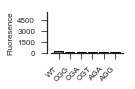

In [113]:
conditions = ['Rich']
times = ['24']
sampleOrder = np.array([5,3,2,4,0,1])
xlocations =np.array([0,1,2,3,4,5])
variants = ['WT','CGG','CGA','CGT','AGA','AGG']

fig = plt.figure()
ax = fig.add_subplot(111)



subset = summarizedDataNoTmp['samplelabel'].apply(lambda label: label.find('conditions') != 'Rich_24')
subsetdata = summarizedDataNoTmp[subset]


ax.bar(xlocations, subsetdata['mean'][sampleOrder], align='center', facecolor = 'grey',edgecolor='black',linewidth=1 )
#ax.errorbar(xlocations, data['relative_s35met'][sampleOrder], 
            #data['sem'][sampleOrder], linestyle='None', color = 'black', elinewidth=0.5, capsize=2, capthick=0.5 )

spineOffset = {'left': 4, 'bottom': 0}   
[ spine.set_position(('outward',spineOffset[loc])) 
     if loc in ['left','bottom'] else spine.set_color('none') 
     for loc, spine in ax.spines.items() ]         
ax.xaxis.set( ticks_position = 'bottom')
ax.yaxis.set( ticks_position = 'left')
ax.yaxis.set( major_locator = MaxNLocator(5) )
ax.set_ylim(0,5500)
ax.set_xticks(xlocations)
xticklabels= variants
ax.set_xticklabels(xticklabels, rotation=45, ha='right')

ax.set_ylabel( 'Fluoresence')

fig.set_size_inches([1.29,.75])

fig.savefig('../figures/rawdata_rich_minustmp_24h.svg')
